# Assignment

### 1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather/home). To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a regression model where the target variable is *temperature*. As explanatory variables, use *humidity*, *windspeed*, *windbearing*, and *pressure*. Estimate the model using OLS.
* Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

```
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
```

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_data = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

**Data Exploration**

In [7]:
# Loading the data:
weather_data.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


In [8]:
# Contents of the data:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


Our dataset includes 12 attributes and 96453 records. Datatypes appear to be numerical with the exception of three categorical object variables. Let's now dive into the statistics of our weather data:

In [10]:
# Descriptive Statistics
weather_data.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,10.855,0.735,10.811,187.509,10.347,0.000,1003.236
std,9.552,10.697,0.195,6.914,107.383,4.192,0.000,116.970
min,-21.822,-27.717,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.689,2.311,0.600,5.828,116.000,8.340,0.000,1011.900
50%,12.000,12.000,0.780,9.966,180.000,10.046,0.000,1016.450
75%,18.839,18.839,0.890,14.136,290.000,14.812,0.000,1021.090
max,39.906,39.344,1.000,63.853,359.000,16.100,0.000,1046.380


Given that temperature is our target variable, this dataset includes 96453 unique temperature counts. The average temperature in Szeged is 11.93 C whereas the median temperature lies at 12 C. Our data indicates that the temperature drops down to -21.822 C which seems extremely cold.

Let's observe the shape of our distribution through a histogram.

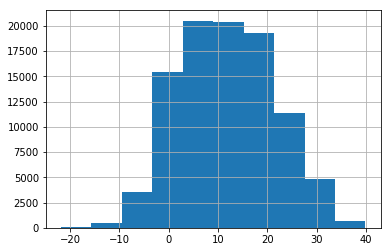

In [12]:
weather_data["temperature"].hist()

**Regression Model**

Our target variable for the model is 'temperature' and the let's use the following explanatory variables to build our Regression Model.
- Humidity
- Windspeed
- Windbearing
- Pressure

In [13]:
# Let's name the variables:

# Y is the target variable
Y =  weather_data['temperature']

# X is the feature set which includes the explanatory variables above:
X = weather_data[['humidity', 'windspeed', 'windbearing', 'pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.926438185285306


Let's now verify our model to see if the assumptions hold true.

**Assumption 1: Linearity of the model in its coefficients**


Coefficients: 
 [2. 3.]

Intercept: 
 0.9999999995343387


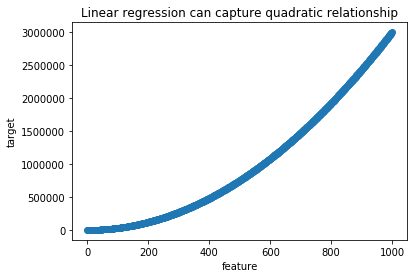

In [14]:
df = pd.DataFrame()

# data from 0 to 999
df["X"] = np.arange(0,1000,1)
# we take the square of X
df["X_sq"] = df["X"]**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df["Y"] = 1 + 2*df["X"] + 3*df["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df[["X","X_sq"]],df["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

**Assumption 2: Error Term should be 0**

In [16]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -7.449232417867907e-16


Since, we include the constant term in the model, the average of the model's error is effectively zero.

**Assumption 3: Homoscedascity**

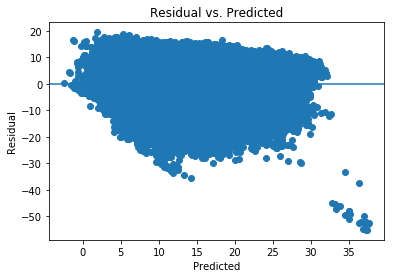

In [17]:
# Visualizing the relationship between the error variance and target variable
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Let's compute Barlett and Levine tests from scipy's stats module to verify homoscedasticity. The null hypothesis for both tests is that the errors are homoscedastic.

In [18]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


The p-values for both tests are 0 which means it is lower than 0.05; therefore, we should reject the null hypothesis. This means our errors are heteroscedastic.

**Assumption 4: Low multicolleaniarity**

Let's verfiy the correlation between variables through the correlation matrix.

In [19]:
correlation_matrix = X.corr()
display(correlation_matrix)

,humidity,windspeed,windbearing,pressure
humidity,1.000,-0.225,0.001,0.005
windspeed,-0.225,1.000,0.104,-0.049
windbearing,0.001,0.104,1.000,-0.012
pressure,0.005,-0.049,-0.012,1.000


**Assumption 5: Error terms should be uncorrelated with one another.**

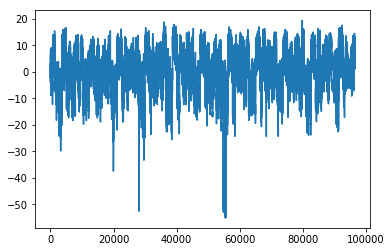

In [20]:
plt.plot(errors)
plt.show()

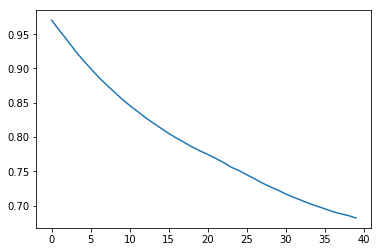

In [21]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

**Assumption six: Features shouldn't be correlated with the errors**

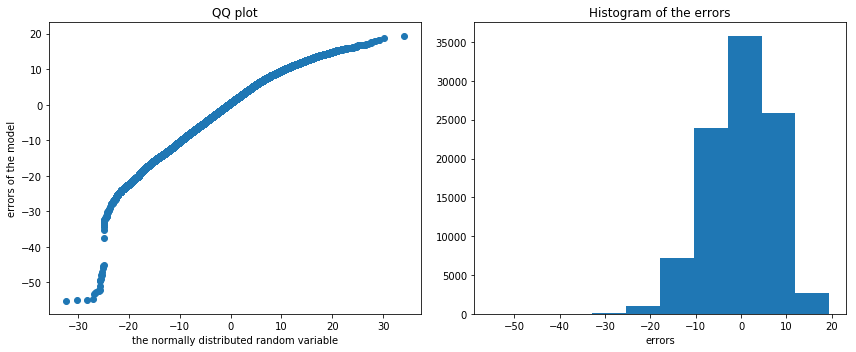

In [22]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

Let's also verify our distribution through Jarque-bera normality test.

In [23]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.2967352523665 and p value is 0.0
Normality test statistics is 3375.432307699586 and p value is 0.0


p-values of both tests indicate that our errors are not normally distributed.